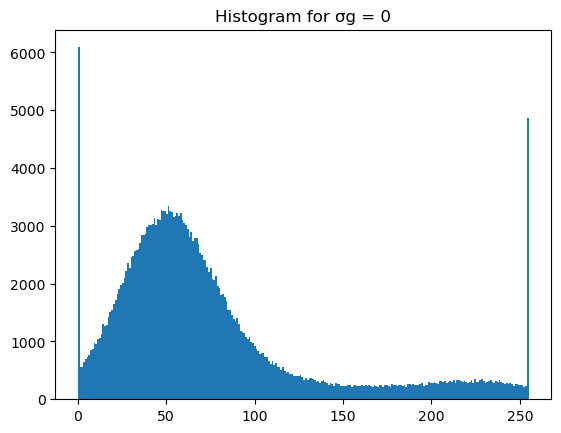

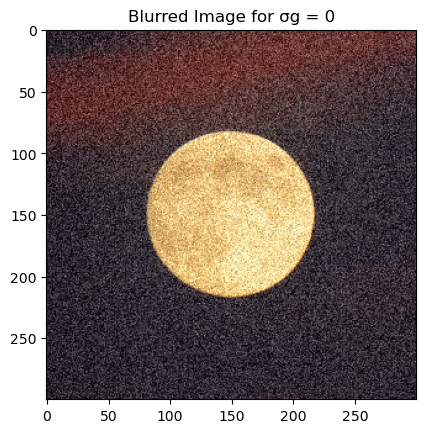

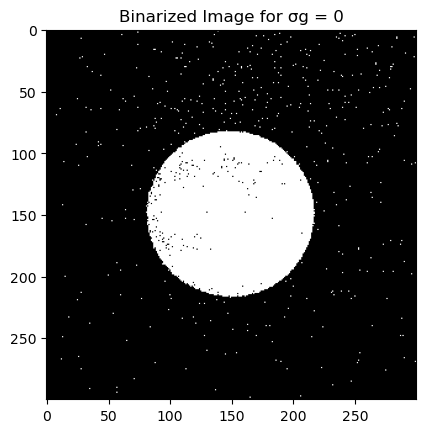

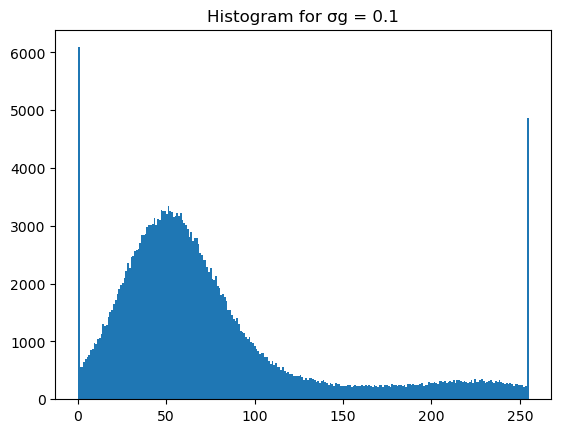

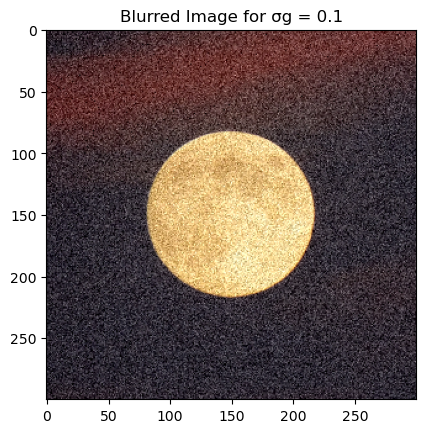

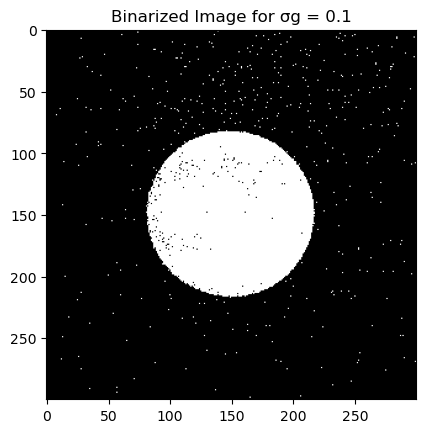

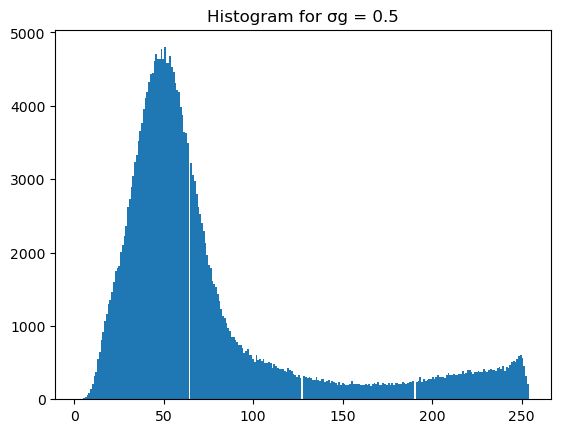

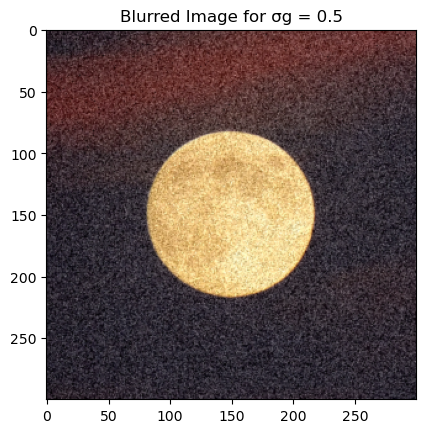

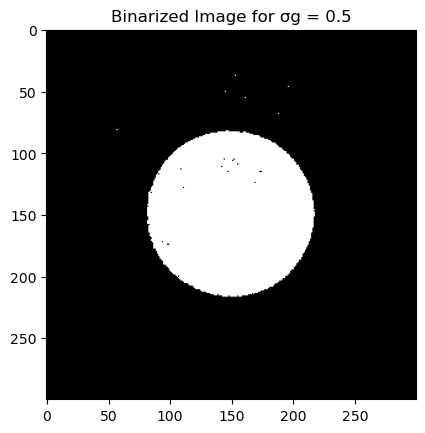

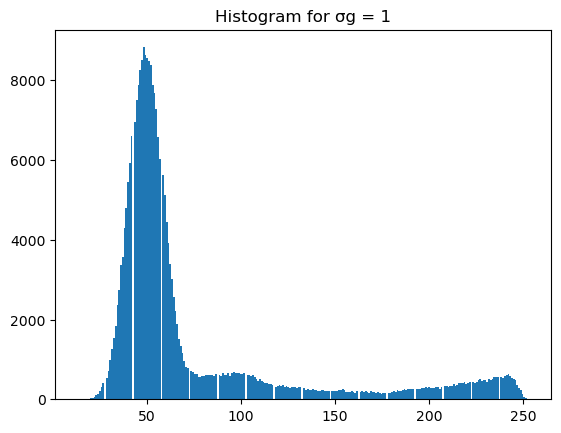

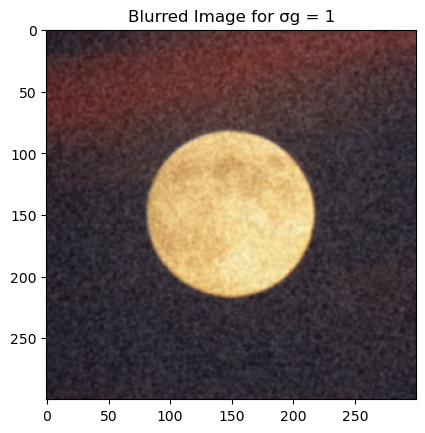

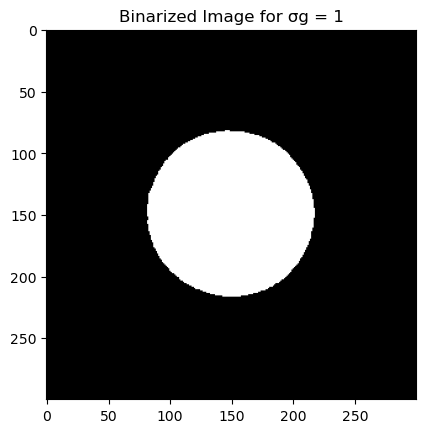

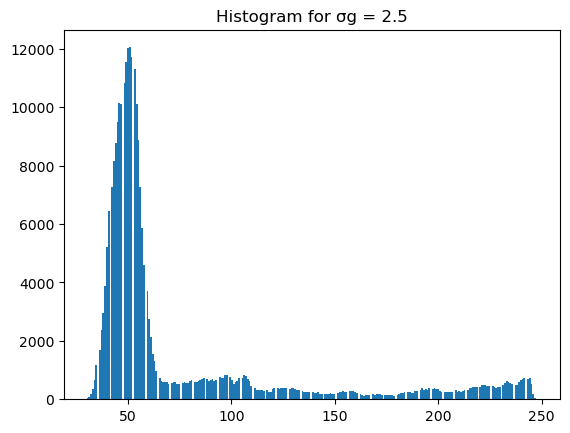

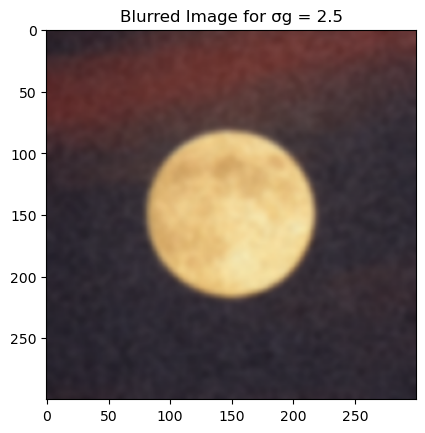

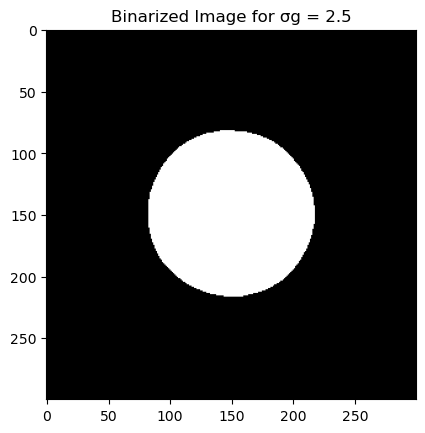

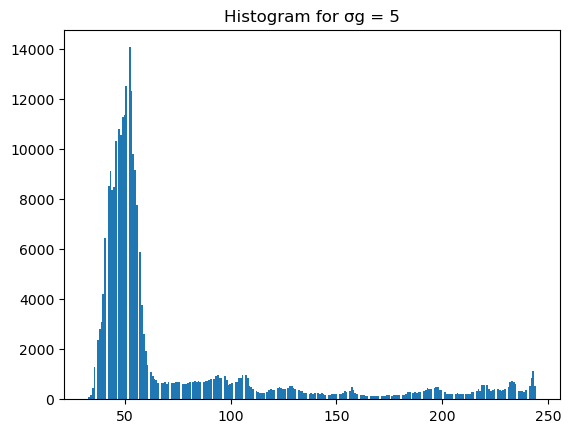

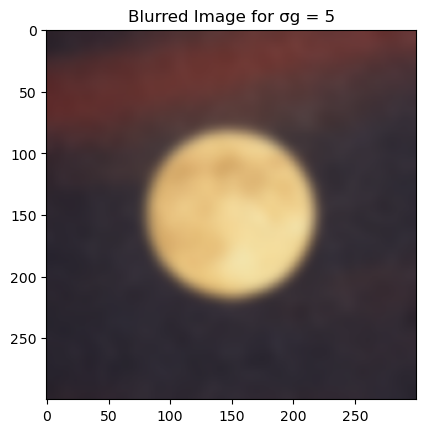

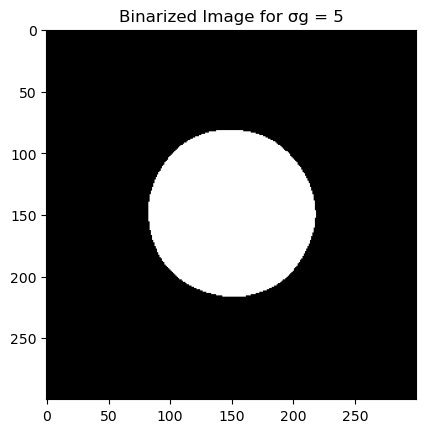

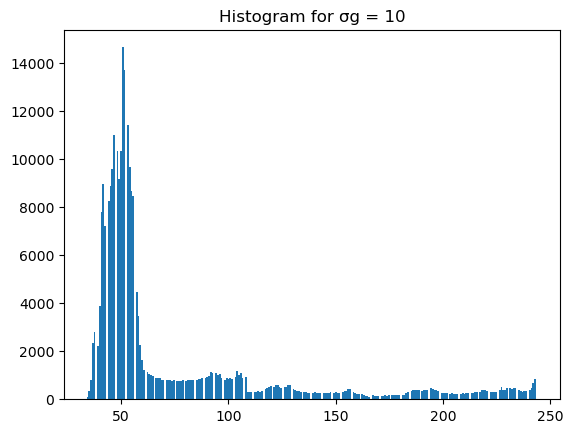

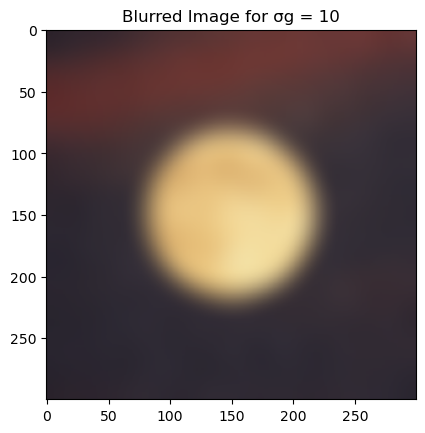

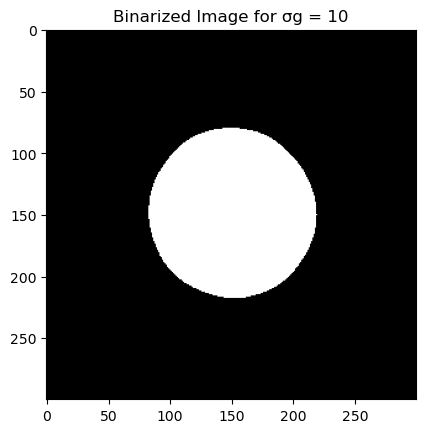

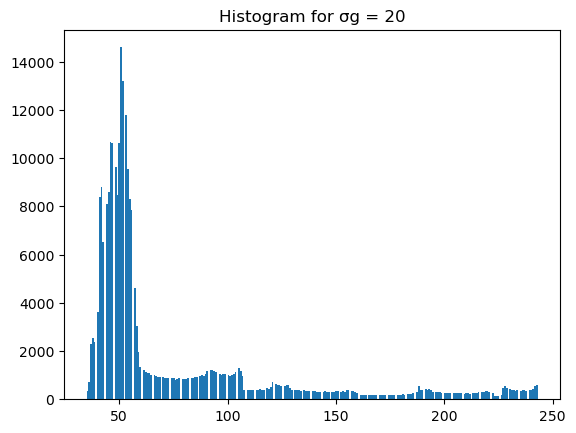

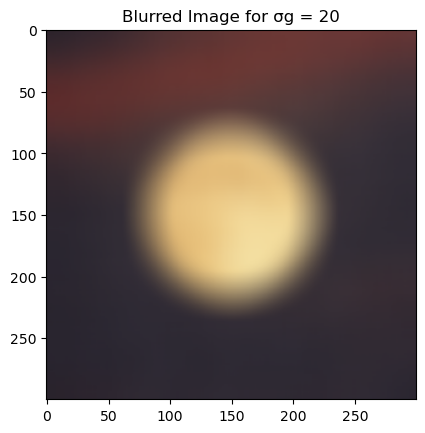

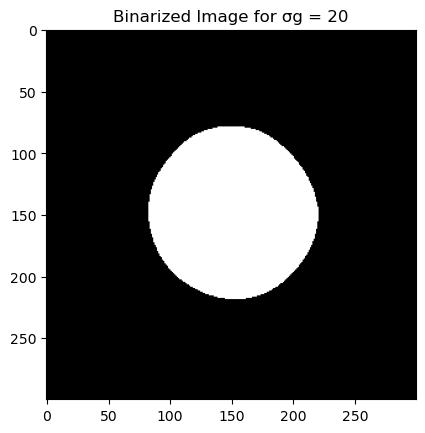

σg = 0: Otsu threshold = 117, within-class variance = 670.8329451085989
σg = 0.1: Otsu threshold = 117, within-class variance = 670.8329451085989
σg = 0.5: Otsu threshold = 117, within-class variance = 334.1161104549546
σg = 1: Otsu threshold = 116, within-class variance = 141.4843976885598
σg = 2.5: Otsu threshold = 115, within-class variance = 123.03704212792402
σg = 5: Otsu threshold = 114, within-class variance = 153.70428252911523
σg = 10: Otsu threshold = 111, within-class variance = 205.71603981439708
σg = 20: Otsu threshold = 109, within-class variance = 238.28945840533436
Optimal σg that minimizes within-class variance: 2.5


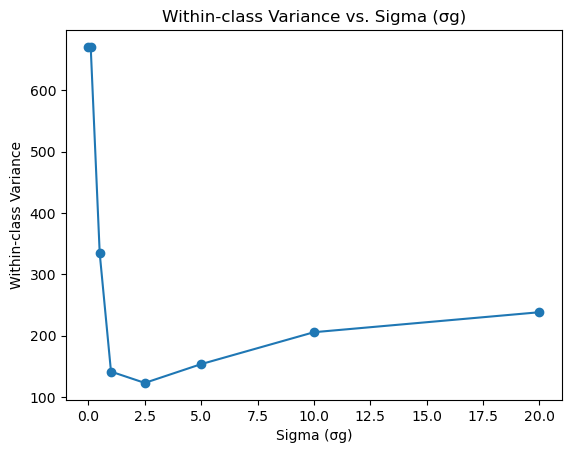

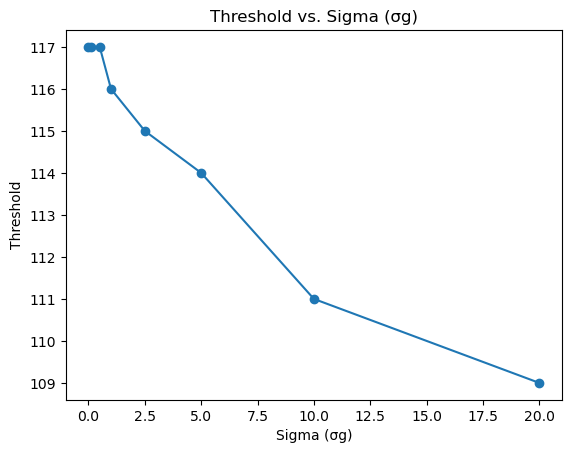

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

def gaussian_filter(size, sigma_g):
    """Create a Gaussian filter based on the given size and sigma."""
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma_g**2))
    return gaussian / np.sum(gaussian) 

def apply_gaussian_blur(image, sigma_g):
    """Apply Gaussian blur to the image using the given sigma."""
    if sigma_g == 0:
        blurred_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return blurred_image
    kernel = gaussian_filter(41, sigma_g)
    blurred_image = image.copy()
    r = convolve(blurred_image[:, :, 0], kernel)
    g = convolve(blurred_image[:, :, 1], kernel)
    b = convolve(blurred_image[:, :, 2], kernel)
    blurred_image[:, :, 0] = b
    blurred_image[:, :, 1] = g
    blurred_image[:, :, 2] = r
    return blurred_image

def otsu_threshold(image):
    """Calculate Otsu's threshold using a direct approach for within-class variance."""
    hist, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    hist_nor = hist / np.sum(hist)
    pixel_values = np.arange(256)

    best_thresh = 0
    best_sig = float('inf')
    track_sig = np.zeros(256)

    for i in range(256):
        w0 = np.sum(hist_nor[:i + 1])
        w1 = 1 - w0

        if w0 == 0 or w1 == 0:
            continue

        u0 = np.sum(pixel_values[:i + 1] * hist_nor[:i + 1]) / w0
        u1 = np.sum(pixel_values[i + 1:] * hist_nor[i + 1:]) / w1

        sig0 = np.sum(((pixel_values[:i + 1] - u0) ** 2) * hist_nor[:i + 1]) / w0
        sig1 = np.sum(((pixel_values[i + 1:] - u1) ** 2) * hist_nor[i + 1:]) / w1

        sig_w = w0 * sig0 + w1 * sig1

        if sig_w < best_sig:
            best_sig = sig_w
            best_thresh = i

        track_sig[i] = sig_w

    return best_thresh, best_sig

def apply_otsu_binarization(image):
    """Binarize the image using Otsu's method."""
    best_thresh, _ = otsu_threshold(image)
    binarized_image = (image >= best_thresh).astype(np.uint8) * 255
    return binarized_image

def plot_histogram(image, sigma_g):
    plt.hist(image.ravel(), bins=256)
    plt.title(f"Histogram for σg = {sigma_g}")
    plt.show()

def plot_blurred_image(image, sigma_g):
    plt.imshow(image)
    plt.title(f"Blurred Image for σg = {sigma_g}")
    plt.show()

def plot_binarized_image(image, sigma_g):
    plt.imshow(image, cmap='gray')
    plt.title(f"Binarized Image for σg = {sigma_g}")
    plt.show()

# Define sigma values to evaluate
sigmas = [0, 0.1, 0.5, 1, 2.5, 5, 10, 20]
within_class_variances = []
thresholds = []

# Load the image
image = cv2.imread('moon_noisy.png')

for i in range(len(sigmas)):
    # Apply Gaussian blur
    blurred_image = apply_gaussian_blur(image, sigmas[i])
    
    # Convert to grayscale
    blurred_image_gray = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Apply custom Otsu binarization and calculate within-class variance
    binarized_image = apply_otsu_binarization(blurred_image_gray)
    thres, within_class_variance = otsu_threshold(blurred_image_gray)  # Track within-class variance
    
    within_class_variances.append(within_class_variance)
    thresholds.append(thres)
    
    # Plot histograms, blurred, and binarized images
    plot_histogram(blurred_image, sigmas[i])
    plot_blurred_image(blurred_image, sigmas[i])
    plot_binarized_image(binarized_image, sigmas[i])

for i in range(len(sigmas)):
    print(f"σg = {sigmas[i]}: Otsu threshold = {thresholds[i]}, within-class variance = {within_class_variances[i]}")

# Find the sigma that minimizes the within-class variance
optimal_sigma_g = sigmas[np.argmin(within_class_variances)]
print(f"Optimal σg that minimizes within-class variance: {optimal_sigma_g}")

# Plot the graph of within-class variances against sigma values
plt.plot(sigmas, within_class_variances, marker='o')
plt.xlabel('Sigma (σg)')
plt.ylabel('Within-class Variance')
plt.title('Within-class Variance vs. Sigma (σg)')
plt.show()
#plot threshold against sigma
plt.plot(sigmas, thresholds, marker='o')
plt.xlabel('Sigma (σg)')
plt.ylabel('Threshold')
plt.title('Threshold vs. Sigma (σg)')
plt.show()


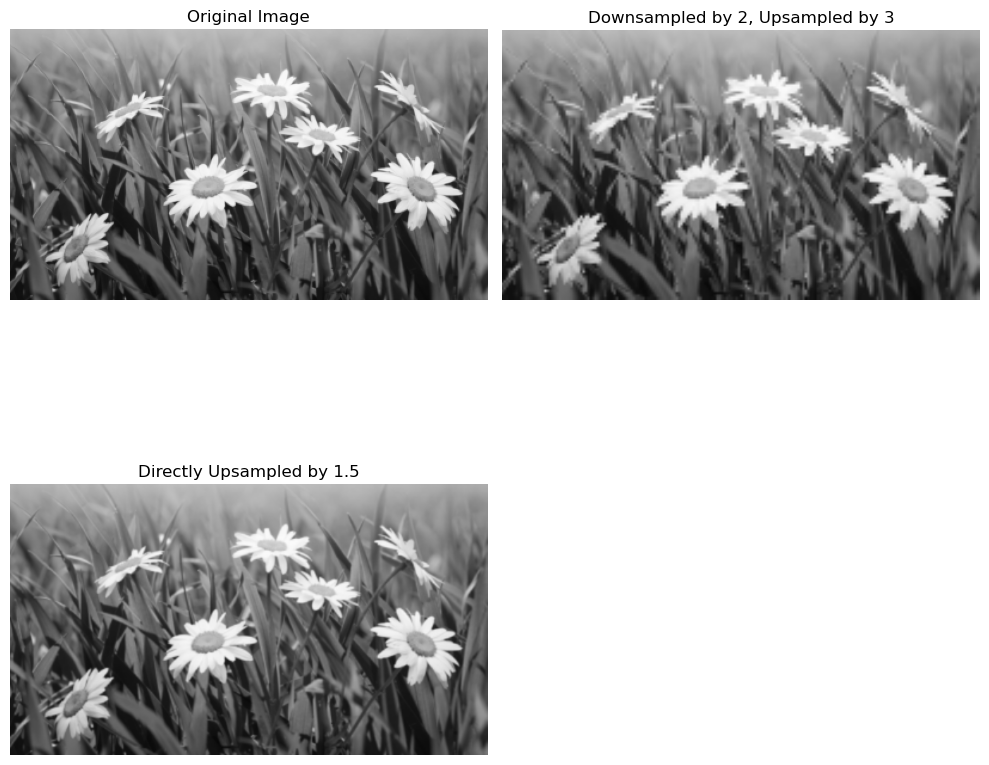

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Bilinear interpolation helper function
def bilinear_interpolate(image, x, y):
    # Define the neighboring points for interpolation
    x0 = int(np.floor(x))
    x1 = min(x0 + 1, image.shape[1] - 1)
    y0 = int(np.floor(y))
    y1 = min(y0 + 1, image.shape[0] - 1)

    # Four surrounding pixels
    Ia = image[y0, x0]
    Ib = image[y1, x0]
    Ic = image[y0, x1]
    Id = image[y1, x1]

    # Handle cases where division by zero might occur (when x0 == x1 or y0 == y1)
    if x0 == x1:
        fx_y0 = Ia  # No interpolation along x if x0 == x1
        fx_y1 = Ib  # No interpolation along x if x0 == x1
    else:
        # Perform Lagrange interpolation along x for y0 and y1
        fx_y0 = (x1 - x) / (x1 - x0) * Ia + (x - x0) / (x1 - x0) * Ic
        fx_y1 = (x1 - x) / (x1 - x0) * Ib + (x - x0) / (x1 - x0) * Id

    if y0 == y1:
        return fx_y0  # No interpolation along y if y0 == y1
    else:
        # Perform Lagrange interpolation along y
        return (y1 - y) / (y1 - y0) * fx_y0 + (y - y0) / (y1 - y0) * fx_y1

# Function for downsampling by a factor
def downsample(image, factor):
    height, width, channels = image.shape
    new_height = height // factor
    new_width = width // factor
    downsampled = np.zeros((new_height, new_width, channels), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            # Map coordinates from new to old image
            old_i = i * factor
            old_j = j * factor
            downsampled[i, j] = image[old_i, old_j]  # Simply take the nearest pixel for downsampling

    return downsampled

# Function for upsampling by a factor using bilinear interpolation
def upsample(image, factor):
    height, width, channels = image.shape
    new_height = int(height * factor)
    new_width = int(width * factor)
    upsampled = np.zeros((new_height, new_width, channels), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            # Map coordinates from new image to old image
            old_x = j / factor
            old_y = i / factor
            for c in range(channels):
                upsampled[i, j, c] = bilinear_interpolate(image[:, :, c], old_x, old_y)

    return upsampled

# Load the image
image = cv2.imread('flowers.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# (a) Downsample by 2 and upsample by 3
downsampled = downsample(image_rgb, 2)
upsampled_after_downsampling = upsample(downsampled, 3)

# (b) Directly upsample by 1.5
upsampled_direct = upsample(image_rgb, 1.5)  # Corrected to upsample by 1.5

# Visualize the results
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Downsampled and then upsampled image
plt.subplot(2, 2, 2)
plt.imshow(upsampled_after_downsampling)
plt.title('Downsampled by 2, Upsampled by 3')
plt.axis('off')

# Directly upsampled image
plt.subplot(2, 2, 3)
plt.imshow(upsampled_direct)
plt.title('Directly Upsampled by 1.5')
plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import numpy as np

def contrast_adjust(img, p):
    """
    Adjust the contrast of the image based on parameter p.
    p=0: grey image
    p=1: binary image
    p=0.5: no change
    """
    # Ensure p is within the valid range
    p = np.clip(p, 0, 1)
    
    # Convert image to float to handle the calculations
    img_float = img.astype(np.float32)
    if p == 0:
        return np.ones_like(img) * 128
    elif p == 1:
        return np.where(img > 128, 255, 0).astype(np.uint8)
    mean = np.mean(img_float)
    if p >=0.5:
        # Contrast decreases from the original image to a grey image
        factor = 1+2*(p-0.5)
    else:
        # Contrast increases from the original image to a binary image
        factor = 2 * p 
        
    adjusted_img = np.clip(mean + factor * (img_float - mean),0, 255).astype(np.uint8)
    
    # Clip values to be in valid range [0, 255] and convert back to uint8
    adjusted_img = np.clip(adjusted_img, 0, 255).astype(np.uint8)
    
    return adjusted_img



In [5]:
def brightness_adjust(img, p):
    """
    Adjust the brightness of the image based on the parameter p.
    
    Parameters:
    img (numpy.ndarray): Input image with pixel values in the range [0, 255].
    p (float): Parameter for brightness adjustment where 0 <= p <= 1.
    
    Returns:
    numpy.ndarray: Brightness-adjusted image.
    """
    if p < 0 or p > 1:
        raise ValueError("p should be between 0 and 1")
    
    # Convert the image to float32 for precise calculation
    img_float = img.astype(np.float32)

    if p == 0:
        # Return a completely black image if p=0
        return np.zeros_like(img)
    elif p == 1:
        # Return a completely white image if p=1
        return np.ones_like(img) * 255
    else:
        # Adjust brightness by adding or subtracting intensity
        # p = 0.5 means no change, so subtracting 0.5 gives us an offset.
        adjustment = (p - 0.5) * 2 * 255  # This scales p to range [-255, +255]
        adjusted_image = img_float + adjustment
        
        # Clip values to be in the valid range [0, 255]
        adjusted_image = np.clip(adjusted_image, 0, 255)
    
    return adjusted_image.astype(np.uint8)

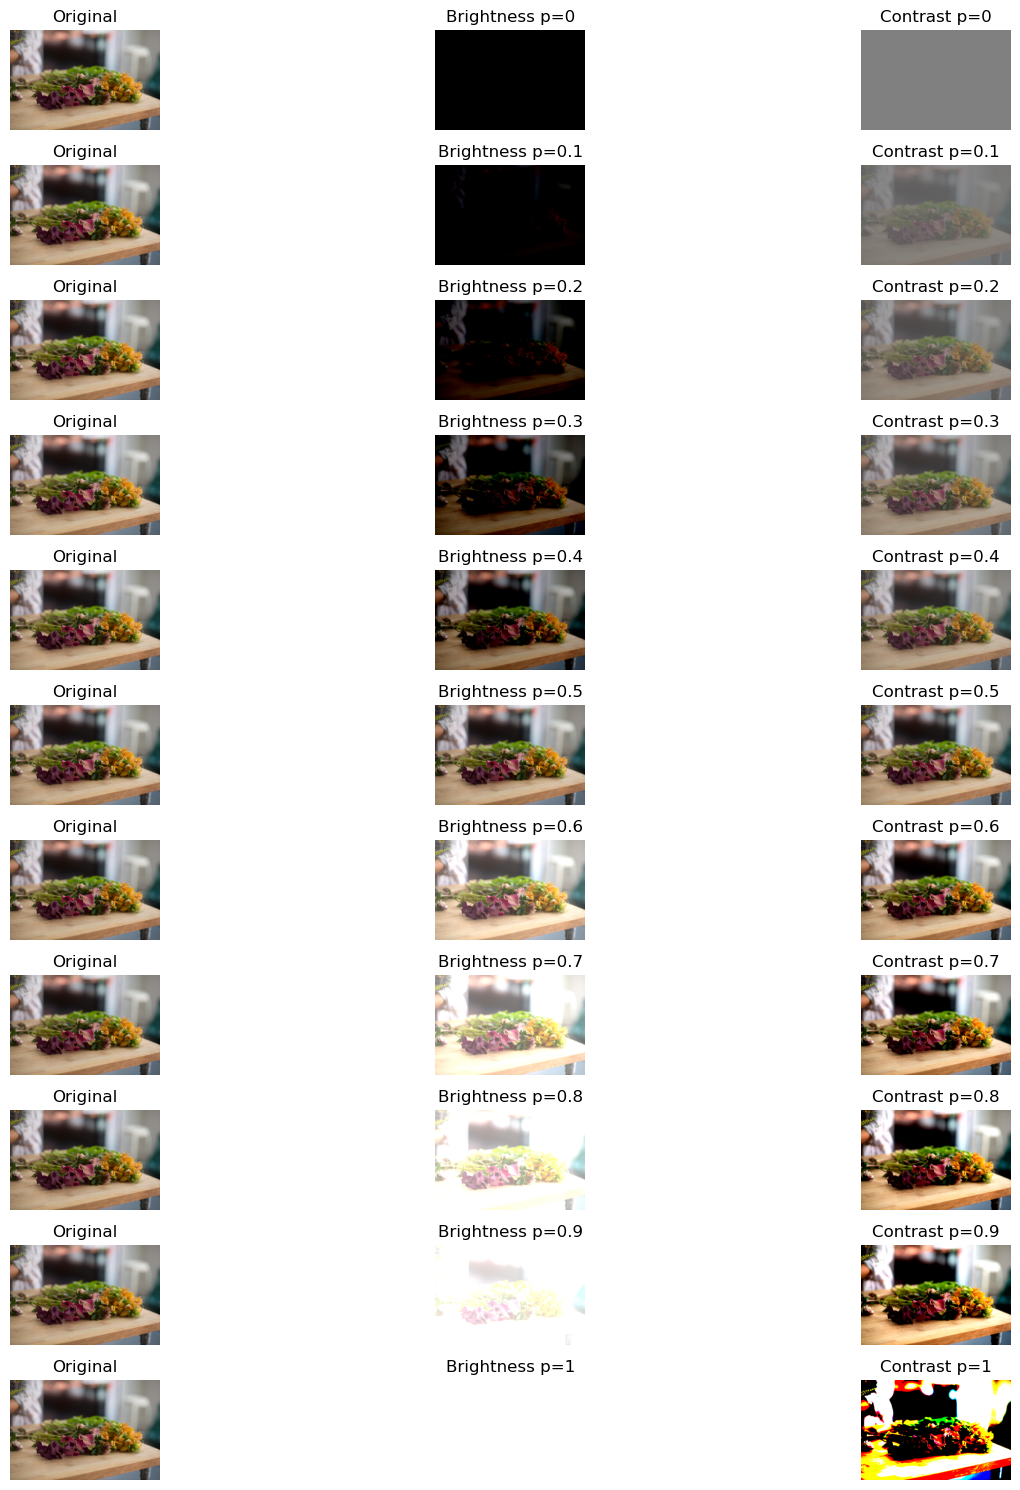

In [6]:
import matplotlib.pyplot as plt
import cv2
# Load the image
image = cv2.imread('brightness_contrast.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply brightness and contrast adjustments
p_values = [0,0.1, 0.2,0.3,0.4,0.5, 0.6,0.7,0.8,0.9, 1]
fig, axes = plt.subplots(len(p_values), 3, figsize=(15, 15))

for i, p in enumerate(p_values):
    # Brightness adjustment
    bright_img = brightness_adjust(image_rgb, p)
    
    # Contrast adjustment
    contrast_img = contrast_adjust(image_rgb, p)
    
    # Plot the results
    axes[i, 0].imshow(image_rgb)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(bright_img)
    axes[i, 1].set_title(f'Brightness p={p}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(contrast_img)
    axes[i, 2].set_title(f'Contrast p={p}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
